<a href="https://www.kaggle.com/code/dhaks13/brain-tumor-segmentation-unet-focalloss?scriptVersionId=190346937" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Modules

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!nvidia-smi

Mon Jul 29 19:38:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Loading Data and split it into train and test

In [4]:
BATCH_SIZE = 4 # Set the batch size
ROOT_DIR = '/kaggle/input/brain-tumor-segmentation/data/Glioma' # Set the root directory to the Glioma dataset

In [5]:
# Define the Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self,images, root_dir, transform=None):
        self.images = images 
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        img_path = os.path.join(self.root_dir, image_name)
        mask_name = image_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.root_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    

In [6]:
# Load the images and masks

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Get the list of images
all_images = [file for file in os.listdir(ROOT_DIR) if file.endswith('.png') and '_mask' not in file]

# Split the images into training and testing sets
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Create the training and testing datasets
train_dataset = BrainTumorDataset(train_files, ROOT_DIR, transform=transform)
test_dataset = BrainTumorDataset(test_files, ROOT_DIR, transform=transform)

# Create the training and testing dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training Batch - Image Shape: torch.Size([4, 3, 512, 512]), Mask Shape: torch.Size([4, 1, 512, 512])


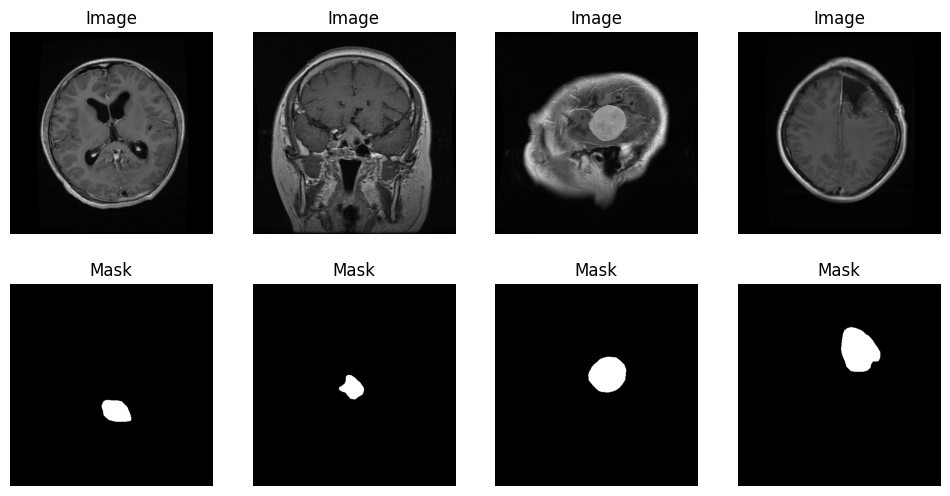

Testing Batch - Image Shape: torch.Size([4, 3, 512, 512]), Mask Shape: torch.Size([4, 1, 512, 512])


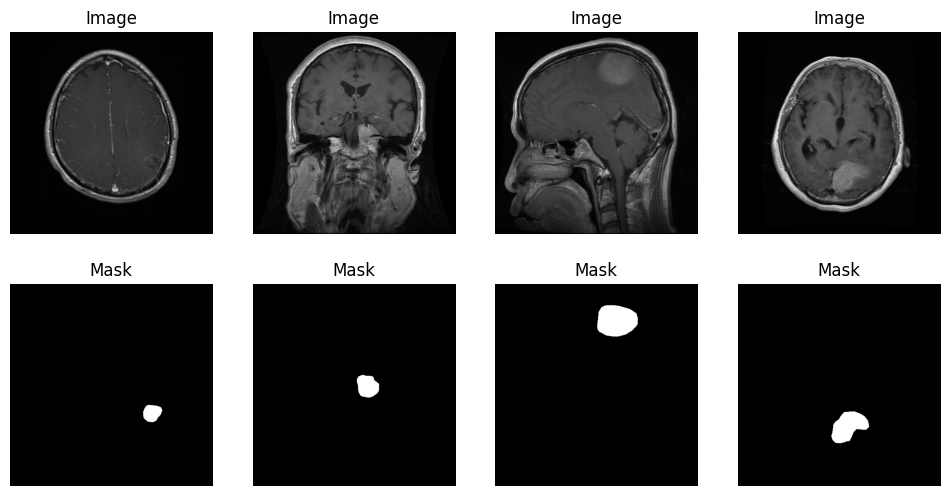

In [7]:
# Display a few images and masks
def display_image_mask(images, masks):
    fig,axes = plt.subplots(2,4,figsize=(12,6))
    for i in range(4):
        axes[0,i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0,i].axis('off')
        axes[1,i].imshow(masks[i][0], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1,i].axis('off')
    plt.show()

# Get a batch of training data
images, masks = next(iter(train_loader))
print(f"Training Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
display_image_mask(images, masks)

# Get a batch of testing data
images, masks = next(iter(test_loader))
print(f"Testing Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
display_image_mask(images, masks)

In [8]:
# Print the number of batches in the train and test loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 285
Number of batches in test loader: 72


# Model Creation

### Parts of U-Net

In [9]:
# Convolution Block
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels,padding = 1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

# Downsample Block 
class DownsampleBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

# Upsample Block
class UpsampleBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels*2, out_channels)
    
    def forward(self, x, down_tensor):
        x = self.upsample(x)
        diffY = down_tensor.size()[2] - x.size()[2]
        diffX = down_tensor.size()[3] - x.size()[3]

        x = torch.nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([down_tensor,x], dim=1)
        x = self.conv(x)
        return x


### U-Net Model

In [10]:
# Defining UNet Model
class UNet(torch.nn.Module):
    # Define the init method
    def __init__(self, in_channels, out_channels):
        # Call the super class constructor
        super(UNet,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Define the Layers
        # Downsample layers
        self.down1 = ConvBlock(in_channels, 64)
        self.down2 = DownsampleBlock(64, 128)
        self.down3 = DownsampleBlock(128, 256)
        self.down4 = DownsampleBlock(256, 512)
        # Bottleneck layers
        self.b = DownsampleBlock(512, 1024)
        # Upsample layers
        self.up1 = UpsampleBlock(1024, 512)
        self.up2 = UpsampleBlock(512, 256)
        self.up3 = UpsampleBlock(256, 128)
        self.up4 = UpsampleBlock(128, 64)
        self.outc = ConvBlock(64, out_channels)

    # Define the forward method
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.b(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
    # Define Checkpointing
    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        

In [11]:
# Function to display images and masks
def compare_segmented(images, preds, masks):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):
        axes[0, i].imshow(images[i].to('cpu').permute(1, 2, 0))
        axes[0, i].set_title('Image')
        axes[0, i].axis('off')
        axes[1, i].imshow(preds[i][0], cmap='gray')
        axes[1, i].set_title('Mask - Predicted')
        axes[1, i].axis('off')
        axes[2, i].imshow(masks[i][0].to('cpu'), cmap='gray')
        axes[2, i].set_title('Mask - Ground Truth')
        axes[2, i].axis('off')
    plt.show()


Output shape:  torch.Size([4, 1, 512, 512])


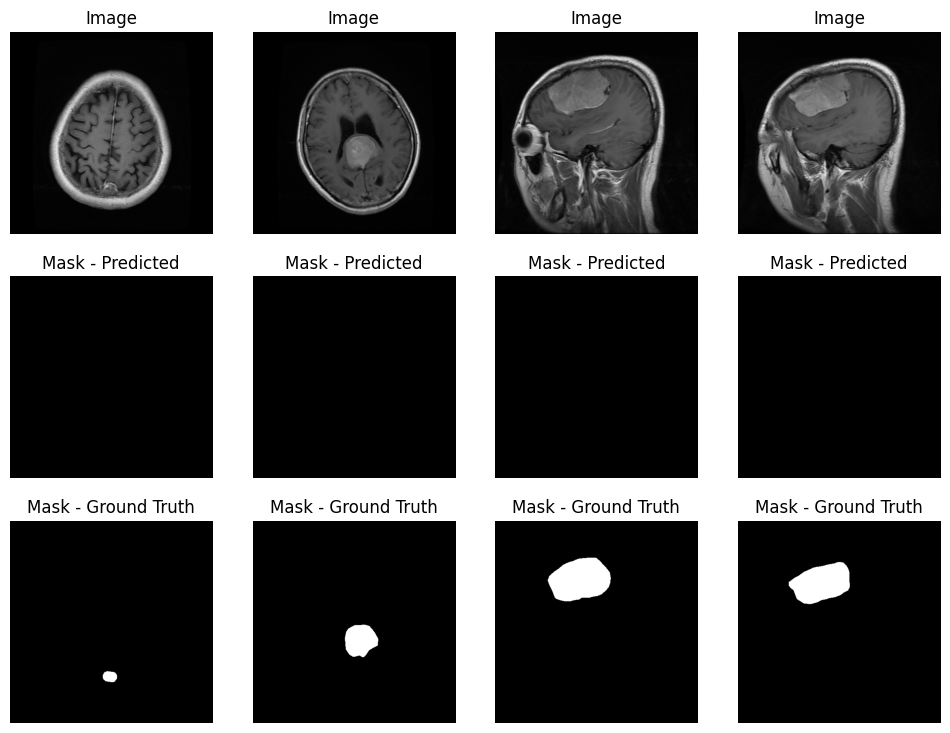

In [12]:
model = UNet(in_channels=3,out_channels=1).to(device)  # Assuming binary segmentation
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images).detach().cpu()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

# Loss function and training loop

In [13]:
# #Creating FocalLoss class for loass funtion

# # https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
# class FocalLoss(torch.nn.Module):
#     def __init__(self,alpha = 0.25,gamma = 2):
#         super(FocalLoss,self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
    
    
#     def forward(self,inputs,targets):
#         p = torch.sigmoid(inputs)
#         ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
#         p_t = p * targets + (1 - p) * (1 - targets)
#         loss = ce_loss * ((1 - p_t) ** self.gamma)

#         if self.alpha >= 0:
#             alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
#             loss = alpha_t * loss
    
#         return loss


In [14]:
# #Creating FocalLoss class for loass funtion
# https://github.com/namdvt/Focal-loss-pytorch-implementation/blob/master/function.py
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = torch.nn.functional.binary_cross_entropy(inputs,  targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [15]:
# Building the train test loop
def train_test_model(model, train_loader, test_loader,
                loss_fn, optimizer,epochs=25,
                device='cpu',save_path='./model.pth'):

    model = model.to(device)
    best_loss = float('inf')
    train_score = []
    test_score = []
    
    # Each loop... Epoch 
    for epoch in range(epochs):
        model.train() #training model
        running_loss = 0.0 #current model loss
        train_epoch = []
        
        # Training loop
        for inputs,masks in tqdm(train_loader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs,masks)
            train_epoch.append(loss)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_score.append(sum(train_epoch)/len(train_epoch))
        print(f'Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}, Train Score: {train_score[-1]:.4f}')
        
        #Evaluate on test data -- testing loop
        model.eval()
        test_epoch = []
        with torch.no_grad():
            for inputs, masks in test_loader:
                inputs = inputs.to(device)
                masks = marks.to(device)
                
                outputs = model(inputs)
                test_epoch.append(loss_fn(outputs,masks))
                
        test_score.append(sum(test_epoch)/len(test_epoch))
        print(f'Test Score: {test_score[-1]:.4f}')
            
        # Save the best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(),save_path)
            print(f'Model weights saved at epoch {epoch} with loss {epoch_loss:.4f}')
            
    return model, train_score, test_score

**Training**

In [16]:
model = UNet(in_channels=3,out_channels=1)  # Assuming binary segmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 16
model, train_dice_scores, test_dice_scores = train_test_model(model, train_loader, test_loader, criterion, optimizer,epochs, device='cuda', save_path='unet_best_model.pth')

 61%|██████▏   | 175/285 [04:11<02:39,  1.45s/it]

**Plotting the FocalLoss Score**

In [ ]:
# Plotting the Dice scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_score, label='Train Score')
plt.plot(test_score, label='Test Score')
plt.xlabel('Epoch')
plt.ylabel('Focal Score')
plt.legend()
plt.title('Focal Scores Over Epochs')
plt.show()

# Output Visualization

#### Visualizing segmented train and test images vs ground truth

In [ ]:
#train images
for images, masks in train_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

In [ ]:
#test images
for images, masks in test_loader:
    outputs = model(images.to(device)).detach().cpu().numpy()
    print("Output shape: ",outputs.shape)
    compare_segmented(images, outputs, masks)
    break

#### Reference:
* https://www.kaggle.com/code/christianmariothomas/brain-tumor-segmentaion-unet
* https://www.kaggle.com/code/akshitsharma1/unet-architecture-explained-in-one-shot-tutorial
* https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
* https://www.youtube.com/watch?v=V_xro1bcAuA